In [48]:
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np

In [49]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [50]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

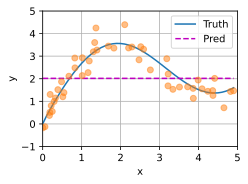

In [51]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

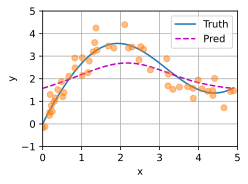

In [52]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

In [94]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [ ]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

In [108]:
X_tile.shape

torch.Size([50, 50])

In [112]:
(1 - torch.eye(n_train)).type(torch.bool)

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True, False]])

In [104]:
a = torch.rand(3,3)
a.reshape((3, -1)).shape

torch.Size([3, 3])

In [96]:
X_tile.shape

torch.Size([50, 50])

In [97]:
Y_tile.shape

torch.Size([50, 50])

In [99]:
(1 - torch.eye(n_train)).shape

torch.Size([50, 50])

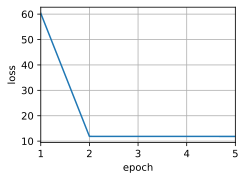

In [95]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

In [90]:
net = NWKernelRegression()

In [91]:
print(list(net.named_parameters()))

[('w', Parameter containing:
tensor([0.8623], requires_grad=True))]


In [53]:
X_repeat.shape

torch.Size([50, 50])

In [54]:
x_train.shape

torch.Size([50])

In [64]:
attention_weights.shape

torch.Size([50, 50])

In [68]:
y_train.shape

torch.Size([50])

In [66]:
y_hat.shape

torch.Size([50])

In [70]:
a = torch.tensor([[1,2,3],[1,2,3],[1,2,3]])
b = torch.tensor([1,2,3])
torch.matmul(a,b)

tensor([14, 14, 14])

In [56]:
X_repeat = x_test.repeat_interleave(n_train)
X_repeat==torch.repeat_interleave(x_test,n_train)

tensor([True, True, True,  ..., True, True, True])

In [57]:
attention_weights.shape

torch.Size([50, 50])

In [58]:
torch.matmul(torch.tensor([1,2,3]),torch.tensor([1,2,3]))

tensor(14)

In [59]:
attention_weights.unsqueeze(0).shape

torch.Size([1, 50, 50])

In [60]:
attention_weights.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 50, 50])

In [61]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [62]:
values.unsqueeze(-1).shape

torch.Size([2, 10, 1])

In [63]:
weights.unsqueeze(1).shape

torch.Size([2, 1, 10])

In [113]:
a = torch.Tensor([[0,2,3],[1,2,3]]).type(torch.bool)
a[a]

tensor([True, True, True, True, True])